### Scenario

Given a list of services and their historical pricing, determine what the average price is is per service while filtering out any extremities.

Goal is to learn how to:
1. Apply standard deviation
2. Determine normal distribution vs. skewed distribution
3. Present my findings in a scientific way using Jupyter

### 0. Setup
---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Import data
---

In [16]:
filename = 'pricing_per_service_data.xlsx'
data = pd.read_excel(filename)
print(data)

        Services   Pricing
0      Service 2    241.46
1      Service 1    332.71
2      Service 5  42793.33
3      Service 1    441.33
4      Service 2    274.51
...          ...       ...
77433  Service 1    504.67
77434  Service 1    237.33
77435  Service 5      0.67
77436  Service 3    475.33
77437  Service 1    237.33

[77438 rows x 2 columns]


### 2. Distribution
---
Now we need to determine the type of distribution. We can do this by using plotting a histogram on any service.

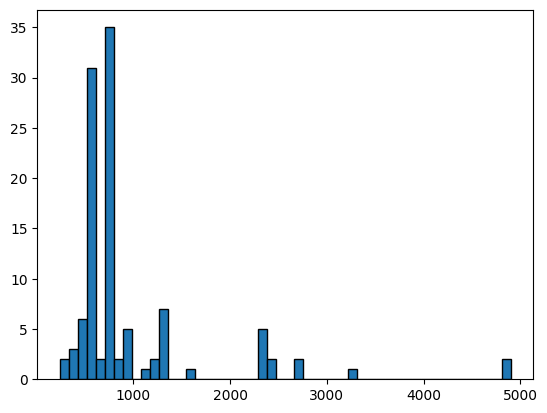

In [17]:
plt.hist(data.query('Services == "Service 4"')['Pricing'], bins=50, edgecolor='black')
plt.show()

From the image above, we can conclude that the data is demonstrating a right-skewed distribution [[1](https://www.investopedia.com/terms/s/skewness.asp)]

We can confirm this by calculating the mean and median. If mean > median then right-skewed, else if mean < median then left-skewed.

In [20]:
data_mean = data.groupby(by=["Services"]).mean().reset_index()
data_mean = data_mean.rename(columns= {"Pricing":"mean_price"})

data_median = data.groupby(by=["Services"]).median().reset_index()
data_median = data_median.rename(columns= {"Pricing":"median_price"})

print(pd.merge(data_mean, data_median, on="Services", how="left"))

    Services   mean_price  median_price
0  Service 1   352.532924        299.33
1  Service 2   535.003393        497.33
2  Service 3   685.267138        589.33
3  Service 4   965.848165        717.33
4  Service 5  1124.740546        758.67
5  Service 6  3302.965842       2133.33


### 3. Determine the range of acceptable pricing using standard deviation
---
Normally applying 2 times standard deviation from the mean would represent ~95% of the data while filtering any extremities.

In this case we cannot expect ~95% but can still apply standard deviation in hopes of removing the outliers on the right while still representing a large amount of the data.

Let's start by defining the upper and lower bounds of what price is acceptable per service using 1 time standard deviation.

In [30]:
data_stddev = data.groupby(by=["Services"]).std().reset_index()
data_stddev = data_stddev.rename(columns= {"Pricing":"stddev_price"})
bounds = pd.merge(data_mean, data_stddev, on="Services", how="left")
                  
stddev_num = 1
bounds = bounds.assign(lower_bound = bounds.mean_price - stddev_num*bounds.stddev_price)
bounds = bounds.assign(upper_bound = bounds.mean_price + stddev_num*bounds.stddev_price)
print(bounds)

    Services   mean_price  stddev_price  lower_bound  upper_bound
0  Service 1   352.532924    304.941903    47.591021   657.474827
1  Service 2   535.003393    401.600162   133.403231   936.603555
2  Service 3   685.267138    502.968078   182.299061  1188.235216
3  Service 4   965.848165    790.463817   175.384348  1756.311982
4  Service 5  1124.740546   1462.001601  -337.261055  2586.742147
5  Service 6  3302.965842   2848.286837   454.679004  6151.252679


### 4. Apply bounds
---
Now we apply our bounds and label each row with a decision: keep or delete.

In [34]:
data_filtered = pd.merge(data, bounds, on="Services", how="left")
data_filtered['decision'] = data_filtered.apply(lambda row: "keep" if (row['lower_bound'] <= row['Pricing'] and row['Pricing'] <= row['upper_bound']) else "delete", axis=1)
print(data_filtered)

        Services   Pricing   mean_price  stddev_price  lower_bound  \
0      Service 2    241.46   535.003393    401.600162   133.403231   
1      Service 1    332.71   352.532924    304.941903    47.591021   
2      Service 5  42793.33  1124.740546   1462.001601  -337.261055   
3      Service 1    441.33   352.532924    304.941903    47.591021   
4      Service 2    274.51   535.003393    401.600162   133.403231   
...          ...       ...          ...           ...          ...   
77433  Service 1    504.67   352.532924    304.941903    47.591021   
77434  Service 1    237.33   352.532924    304.941903    47.591021   
77435  Service 5      0.67  1124.740546   1462.001601  -337.261055   
77436  Service 3    475.33   685.267138    502.968078   182.299061   
77437  Service 1    237.33   352.532924    304.941903    47.591021   

       upper_bound decision  
0       936.603555     keep  
1       657.474827     keep  
2      2586.742147   delete  
3       657.474827     keep  
4       9

### 5. Results
---
Filter the data then check the histogram again

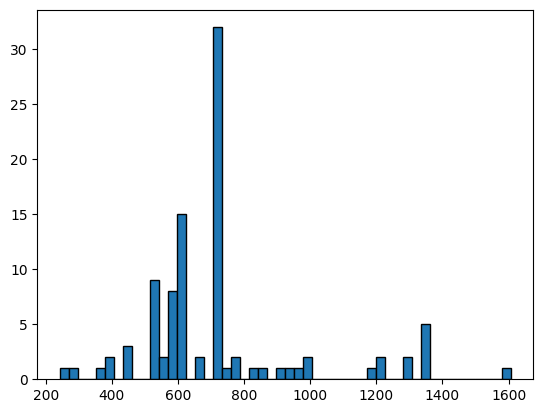

In [36]:
data_filtered = data_filtered.query('decision == "keep"')
plt.hist(data_filtered.query('Services == "Service 4"')['Pricing'], bins=50, edgecolor='black')
plt.show()

### 6. Conclusion
---
After filtering out the extremities, we can see that the peak is now closer to the center of the distribution.
We can also check how much of the data is being represented after filtering

In [47]:
data_representation = pd.merge(data.groupby(by=["Services"]).count(), data_filtered[["Services", "decision"]].groupby(by=["Services"]).count(), on="Services", how="left")
#data_filtered['decision'] = data_filtered.apply(lambda row: "keep" if (row['lower_bound'] <= row['Pricing'] and row['Pricing'] <= row['upper_bound']) else "delete", axis=1)
data_representation = data_representation.assign(Percentage = data_representation.decision/data_representation.Pricing*100)
print(data_representation)

           Pricing  decision  Percentage
Services                                
Service 1    51683     49360   95.505292
Service 2    16813     15790   93.915423
Service 3     1929      1710   88.646967
Service 4      109        97   88.990826
Service 5     6298      5781   91.791045
Service 6      606       511   84.323432
